# Machine Learning Nanodegree - Capstone Project

## Who is in the photo?

The proposal of this project is to build a model that allow to recognize persons in the image using Deep Learning.

### Step 0: Import dataset

In [1]:
%matplotlib inline

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_face_dataset(path):
    data = load_files(path)
    general_targets = data['target']
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 16)
    return face_files, face_targets

train_files, train_targets = load_face_dataset('faces2/train')
valid_files, valid_targets = load_face_dataset('faces2/valid')
test_files, test_targets = load_face_dataset('faces2/test')

person_names = [item[12:-1] for item in sorted(glob("faces2/train/*/"))]


print('There are %d total person names.' % len(person_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))

Using TensorFlow backend.


There are 16 total person names.
There are 2803 total face images.

There are 2245 training face images.
There are 277 validation face images.
There are 281 test face images.


#### Loading image data into array

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(100, 100))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#### Loading Image for baseline model

In [3]:
import cv2
from scipy.misc import imread
from scipy.misc import imresize

def load_image_from(img_path):    
   img = cv2.imread(img_path)
#    img = cv2.resize(img,(100,100))
   return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def load_images_from(img_paths):
    images = [load_image_from(path) for path in tqdm(img_paths)]
    return np.array(images)

#### Load tensors to train, test and validations

In [4]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255



100%|██████████| 281/281 [00:00<00:00, 2476.60it/s]


#### Load image to train, test and validations of a baseline model

In [5]:
# base model
base_train_images = load_images_from(train_files).astype('float32')/255
base_test_images = load_images_from(test_files).astype('float32')/255
base_valid_images = load_images_from(valid_files).astype('float32')/255

100%|██████████| 277/277 [00:00<00:00, 4670.85it/s]


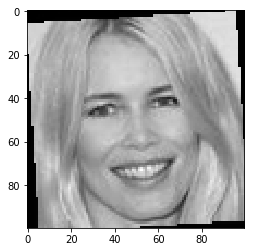

In [6]:
import matplotlib.pyplot as plt                        

img = base_train_images[0]
plt.imshow(img,cmap='gray')
plt.show()

### Step 1:  Train a base line model

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time


#### Create a lookup table

In [8]:
def create_lookup_table(targets):
    lookup = []
    for target in targets:
        index = np.where(target==1)[0]
        lookup.append(index[0])
    return np.array(lookup)


In [9]:
base_train_targets = create_lookup_table(train_targets)
base_test_targets = create_lookup_table(test_targets)
base_valid_targets = create_lookup_table(valid_targets)


#### Creating a function to execute a PCA

In [10]:
def execute_pca(train, test, n_components):
    print("Extracting the top %d eigenfaces from %d faces"
        % (n_components, train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(train)

    print("done in %0.3fs" % (time() - t0))
    # eigenfaces = pca.components_.reshape((n_components, h, w))
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(train)
    X_test_pca = pca.transform(test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca


#### Creating a function to training a model 

In [11]:
def apply_svm(X_train, y_train):
    # Train a SVM classification model
    print "Fitting the classifier to the training set"
#     param_grid = {
#     'C': [1, 5, 10, 50, 100],
#     'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#     }
#     param_grid = {
#         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#     }
    
    param_grid = [
        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
    ]

    clf = GridSearchCV(SVC(kernel='rbf',class_weight='balanced'), param_grid)
    clf = clf.fit(X_train, y_train)
    print "Best estimator found by grid search:"
    print clf.best_estimator_
    return clf


### Exploring and Normalize the dataset

#### Create a function to visualize the dataset

In [12]:
def image_grid(D,H,W,cols=10,scale=1, rows_count=None):
    """ display a grid of images
        H,W: Height and width of the images
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n = np.shape(D)[0]
    if rows_count:
        n = rows_count 
    rows = int(math.ceil((n+0.0)/cols))
    fig = plt.figure(1,figsize=[scale*20.0/H*W,scale*20.0/cols*rows],dpi=300)
    for i in range(n):
        plt.subplot(rows,cols,i+1)
        fig=plt.imshow(np.reshape(D[i,:],[H,W]), cmap = plt.get_cmap("gray"))
        plt.axis('off')

#### Transform the image Matrix in a vector to use in PCA analysis

In [13]:
from PIL import Image       
import glob
import math

def image_to_vector(image_paths, H,W):
    image_count = len(image_paths)
    # and columns as pixels
    arr = np.zeros([image_count,H*W])
    for i in range(image_count):
        im = Image.open(image_paths[i]).convert("L")
        arr[i,:] = np.reshape(np.asarray(im),[1,H*W])
    return arr

In [14]:
def extract_mean(images):
    return np.mean(images, axis=0)


In [15]:
def centralize(images, mean_image, H,W):
    im_number = len(images)
    
    arr_norm = np.zeros([im_number, H*W])
    arr_norm = images - mean_image
    return arr_norm

#### Show some image examples

shape:  (100, 100)


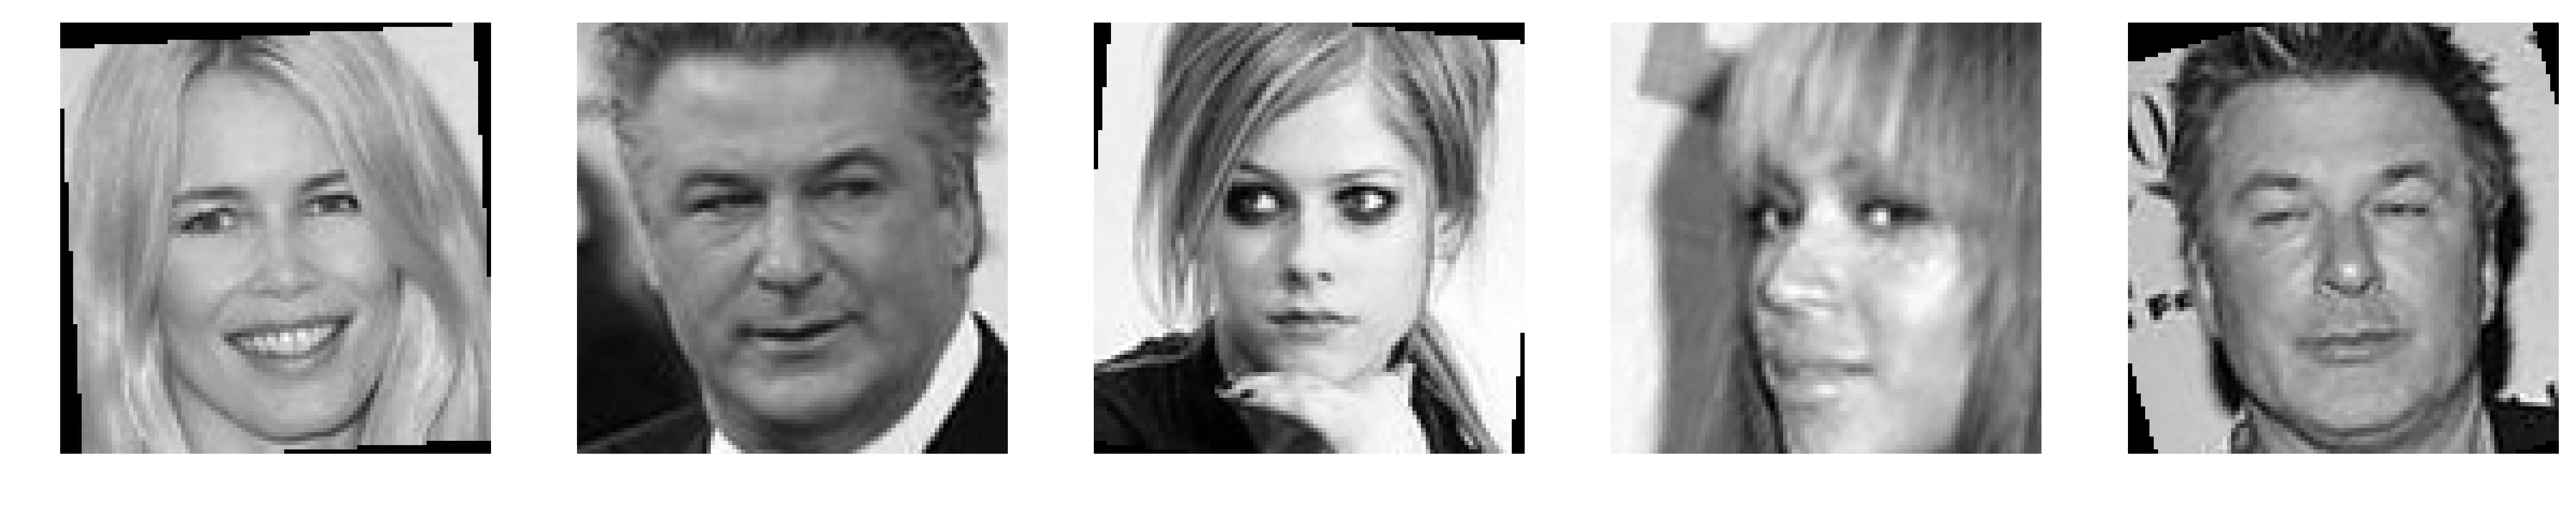

In [16]:

file_list = train_files
im = Image.open(file_list[4]).convert("L")
H,W = np.shape(im)
print 'shape: ', (H,W)

arr = image_to_vector(train_files, H,W)
image_grid(arr,H,W,cols=5,rows_count=5)


#### Apply the mean in the images

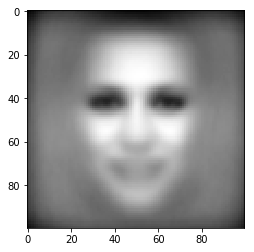

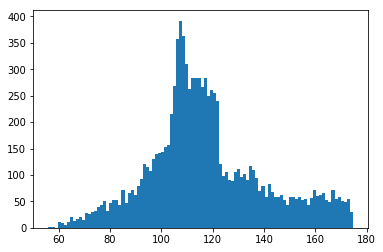

In [17]:
# let's find the mean_image
# mean_image = np.mean(arr, axis=0)
mean_image = extract_mean(arr)

plt.imshow(np.reshape(mean_image,[H,W]), cmap = plt.get_cmap("gray"))
plt.figure()
plt.hist(mean_image,bins=100);

#### Centralize the image

In [18]:
# centering the data (subtract mean face)
# arr_norm = np.zeros([im_number, H*W])
# arr_norm = arr - mean_image
arr_norm = centralize(arr, mean_image, H,W)

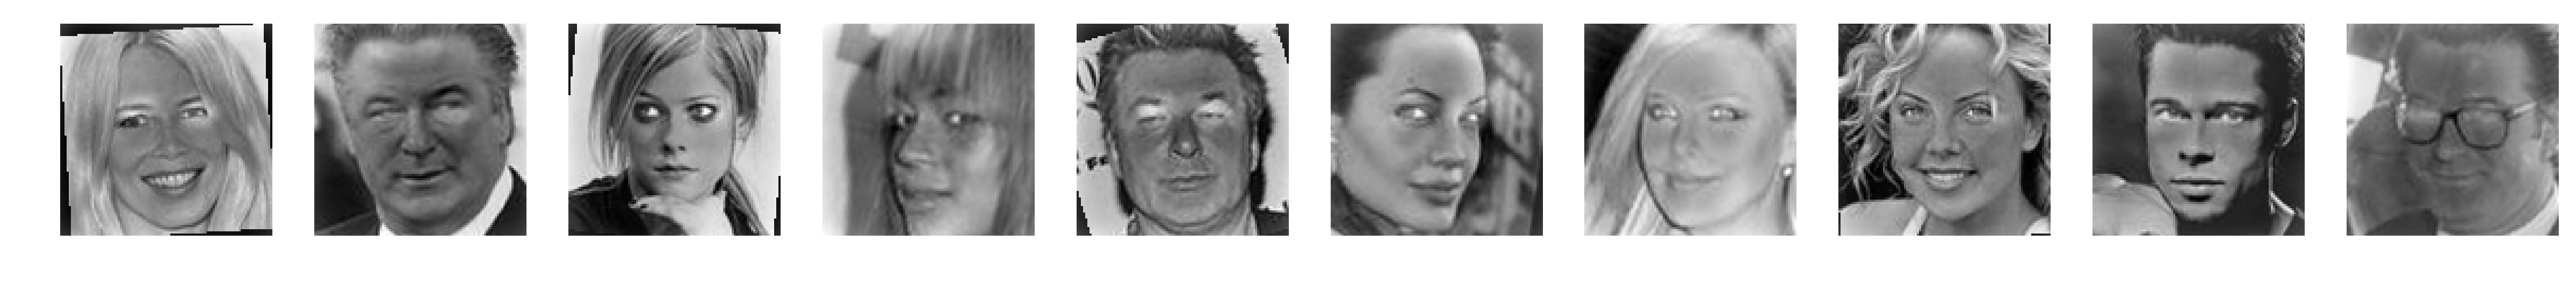

In [19]:
image_grid(arr_norm[:10,:],H,W)

### Train the base model

After some feature engineering, now we can train the model and check the results  .

In [20]:
X_train = base_train_images
y_train = base_train_targets


X_test  = base_test_images
y_test  = base_test_targets


In [21]:
im = Image.open(test_files[0]).convert("L")
H,W = np.shape(im)
print 'shape: ', (H,W)

X_test = image_to_vector(test_files,H,W)
mean_test = extract_mean(X_test)
X_test = centralize(X_test, mean_test, H,W)
print arr_norm.shape
print X_test.shape

X_train_pca, X_test_pca = execute_pca(arr_norm, X_test, n_components=160)
pca = PCA(n_components=160, svd_solver='randomized')
pca.fit(arr_norm)

shape:  (100, 100)
(2245, 10000)
(281, 10000)
Extracting the top 160 eigenfaces from 2245 faces
done in 9.328s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.608s


PCA(copy=True, iterated_power='auto', n_components=160, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

Text(0.5,0,u'Principal Component Number')

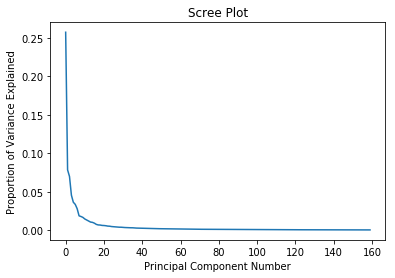

In [23]:
# Let's make a scree plot
pve = pca.explained_variance_ratio_
pve.shape
plt.plot(range(len(pve)), pve)
plt.title("Scree Plot")
plt.ylabel("Proportion of Variance Explained")
plt.xlabel("Principal Component Number")


#### Check the eingenfaces

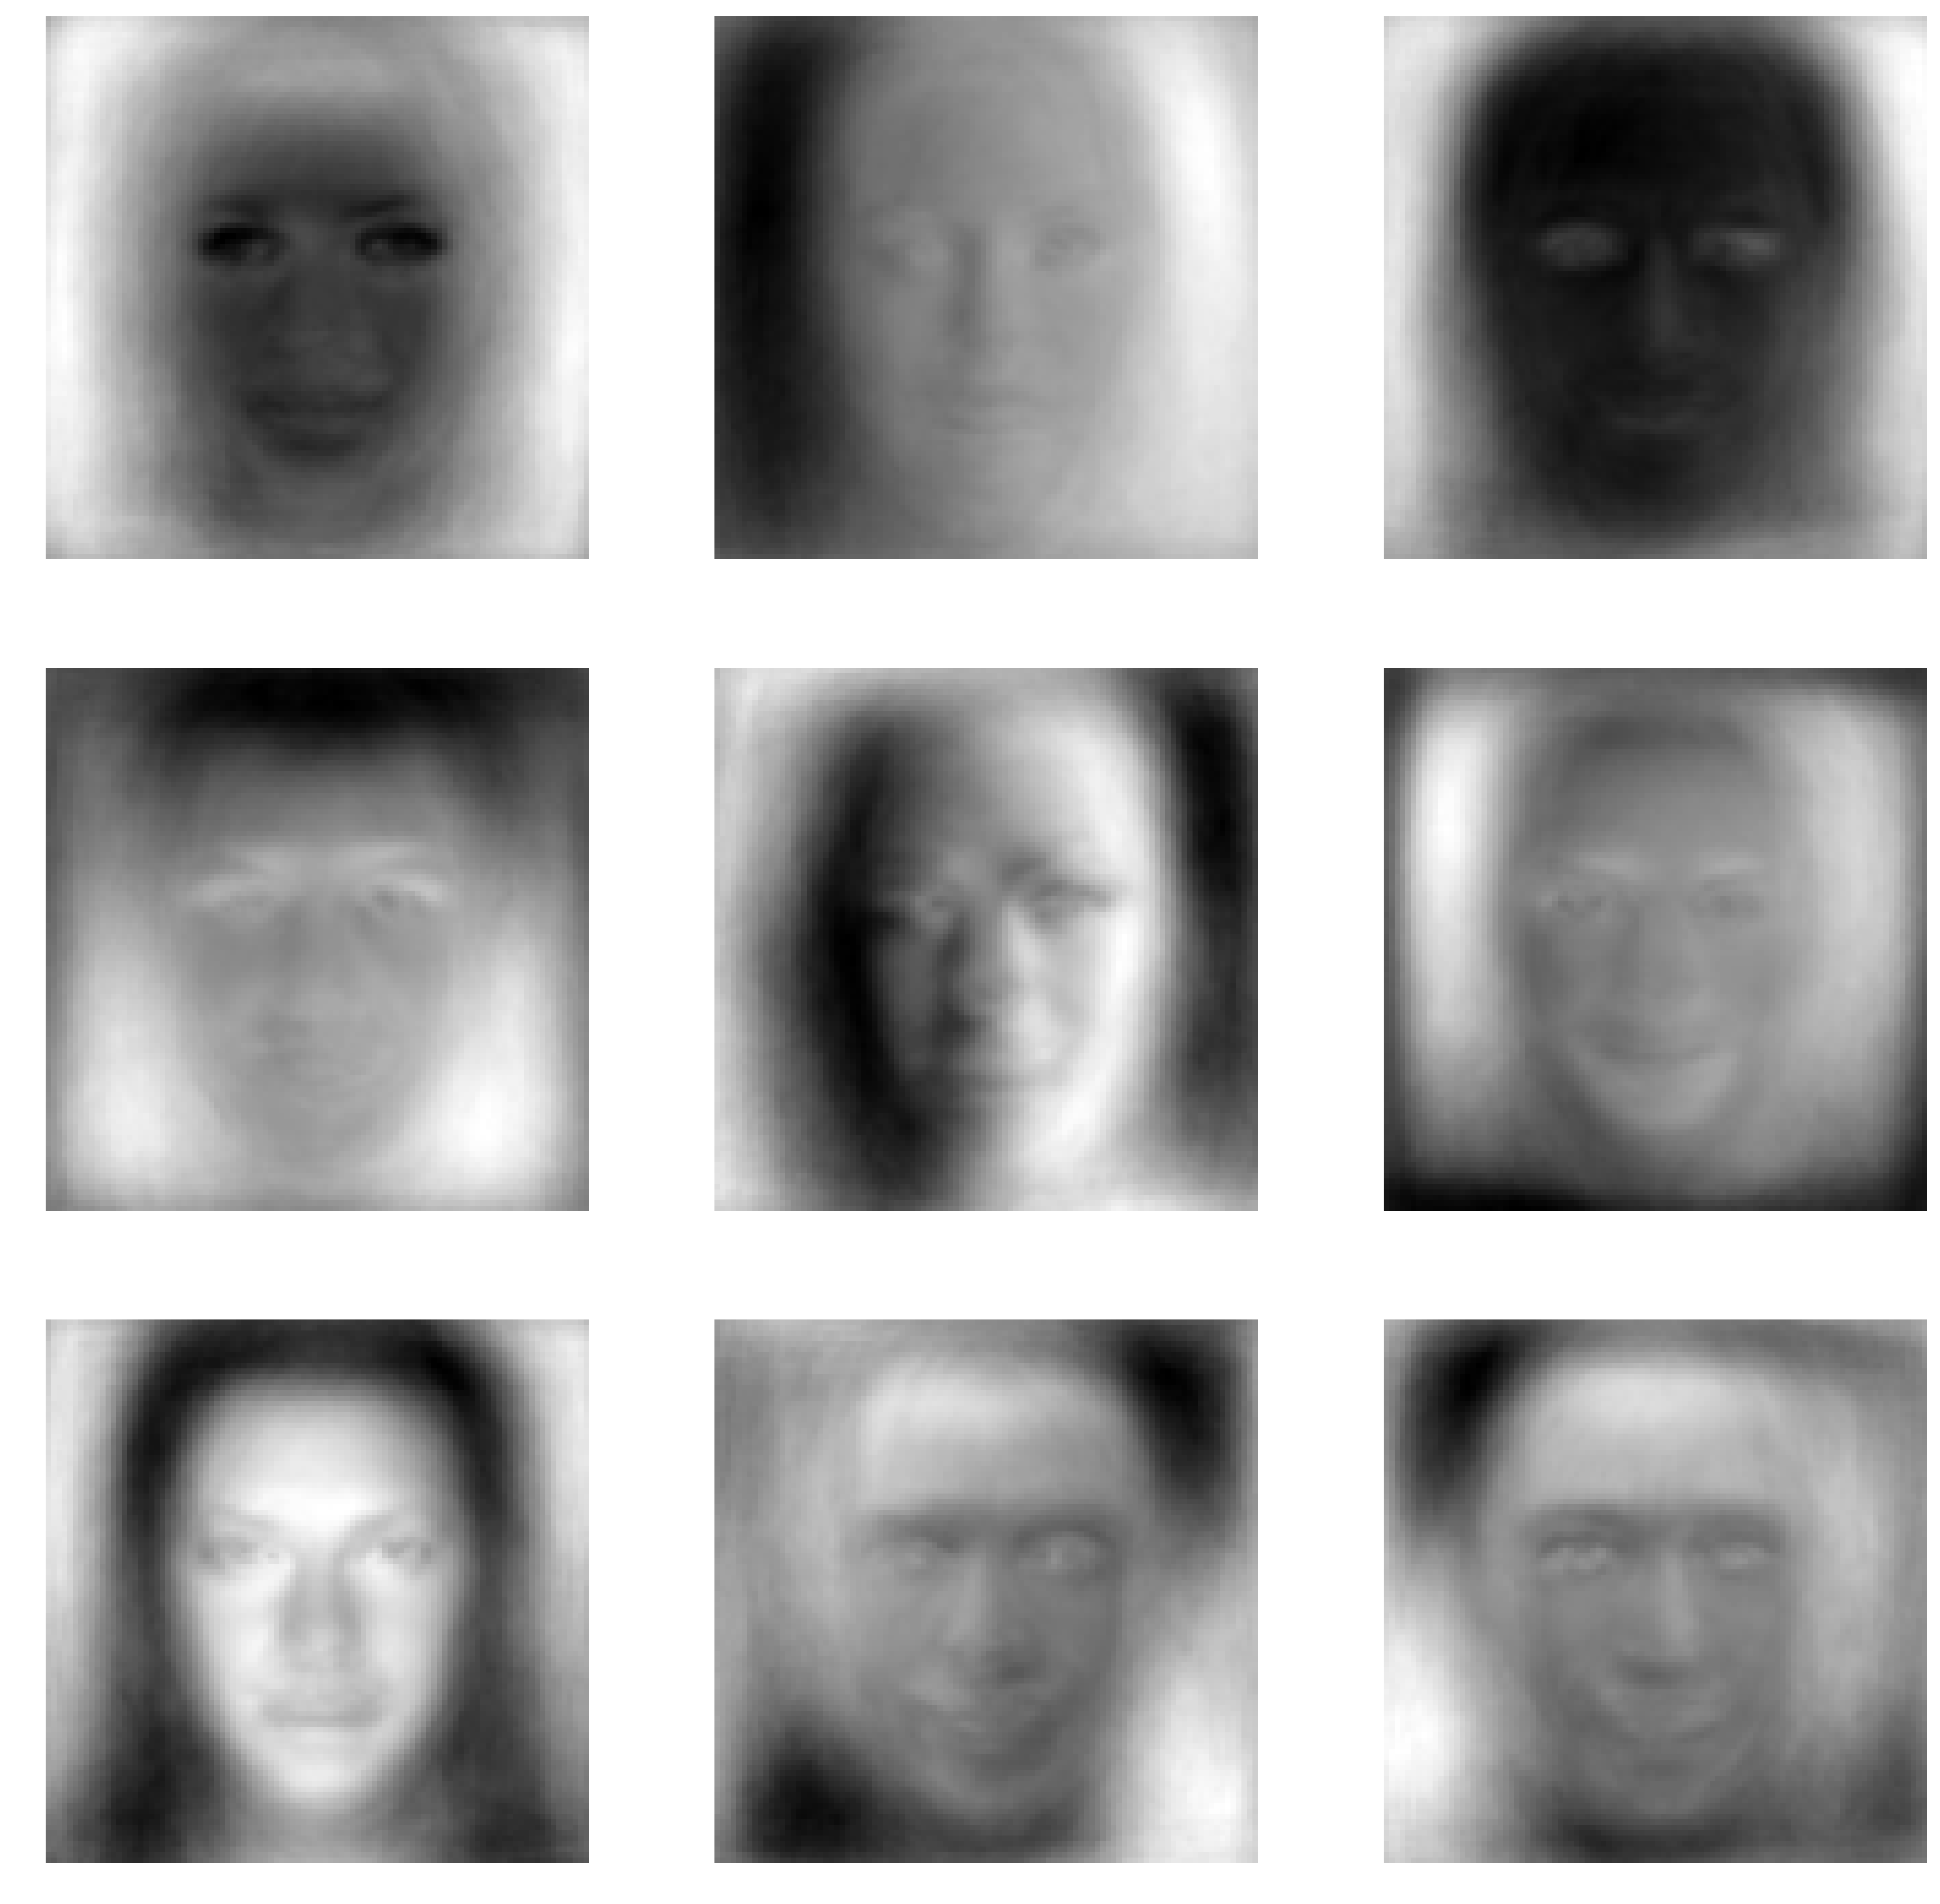

In [24]:
eigenfaces = pca.components_
image_grid(eigenfaces[:9,:], H, W, cols=3)

In [25]:
clf = apply_svm(X_train_pca, y_train)


Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [26]:
y_pred = clf.predict(X_test_pca)
print classification_report(y_test, y_pred, target_names=person_names)

print confusion_matrix(y_test, y_pred, labels=range(len(person_names)))


                   precision    recall  f1-score   support

    /Adam Sandler       0.46      0.55      0.50        11
    /Alec Baldwin       0.43      0.60      0.50        10
  /Angelina Jolie       0.46      0.52      0.49        21
 /Anna Kournikova       0.37      0.41      0.39        17
  /Ashton Kutcher       0.44      0.40      0.42        10
   /Avril Lavigne       0.59      0.57      0.58        30
    /Barack Obama       0.54      0.56      0.55        27
     /Ben Affleck       0.23      0.25      0.24        12
 /Beyonce Knowles       0.67      0.46      0.55        13
       /Brad Pitt       0.48      0.43      0.46        30
    /Cameron Diaz       0.64      0.56      0.60        25
  /Cate Blanchett       0.70      0.44      0.54        16
 /Charlize Theron       0.30      0.30      0.30        20
 /Christina Ricci       0.38      0.43      0.40        14
/Claudia Schiffer       0.36      0.42      0.38        12
      /Clive Owen       0.43      0.46      0.44       

In [27]:
from sklearn.metrics import accuracy_score


In [28]:
accuracy_score(y_test, y_pred)

0.46975088967971529

### Training a haar_cascade model with OpenCV

In [51]:
import cv2
import face_recognition

def get_label(path):
    values = path.split('/')
    if not values:
        return ''
    return values[2]

def trainning_dataset(paths, detect_faces=False):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    detector= cv2.CascadeClassifier("/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml");
    images = []
    labels = []
    description_labels = {}
    id = 0
    paths.sort()
    print "tá indo"
    current_label = get_label(paths[0])
    for image_path in tqdm(paths):
        if current_label != get_label(image_path):
            description_labels[id] = current_label
            current_label = get_label(image_path)
            id += 1
        image_pil = Image.open(image_path).convert('L')
        image = np.array(image_pil, 'uint8')
        image = cv2.equalizeHist(image)
        if detect_faces:
            faces = detector.detectMultiScale(image)
            #If a face is there then append that in the list as well as Id of it
            for (x,y,w,h) in faces:
                images.append(image[y:y+h,x:x+w])
                labels.append(id)
        else:
            images.append(image)
            labels.append(id)
                
    recognizer.train(images, np.array(labels))
    recognizer.save('trainning/trainner.yml')
    return recognizer, description_labels 

   
def preprocessing(paths):
    file_list = paths
    im = Image.open(file_list[0]).convert("L")
    H,W = np.shape(im)
    arr = image_to_vector(file_list, H,W)
    mean_image = extract_mean(arr)
    arr_norm = centralize(arr, mean_image, H,W)
    return arr_norm
    #return np.reshape(arr_norm,[H,W])

    
def trainning_with_preprocessing(paths, detect_faces=False):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    detector= cv2.CascadeClassifier("/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml");
    images = []
    labels = []
    description_labels = {}
    id = 0
    paths.sort()
    current_label = get_label(paths[0])
    load_images = preprocessing(paths)
    
    for i,image in enumerate(tqdm(load_images)):
        if current_label != get_label(paths[i]):
            description_labels[id] = current_label
            current_label = get_label(paths[i])
            id += 1
        image = np.array(image, 'uint8')
        if detect_faces:
            faces = detector.detectMultiScale(image)
            #If a face is there then append that in the list as well as Id of it
            for (x,y,w,h) in faces:
                images.append(image[y:y+h,x:x+w])
                labels.append(id)
        else:
            images.append(image)
            labels.append(id)
    print len(images)
    image_pil = Image.open(paths[0]).convert('L') 
    image_pil = np.array(image, 'uint8')

    print images[0]
    print image_pil
    print len(labels)
        
    recognizer.train(images, np.array(labels))
    recognizer.save('trainning/trainner.yml')
    return recognizer, description_labels 
        
        
    

  1%|          | 18/2245 [00:00<00:13, 168.23it/s]

tá indo


100%|██████████| 2245/2245 [00:13<00:00, 169.96it/s]


{0: 'Adam Sandler', 1: 'Alec Baldwin', 2: 'Angelina Jolie', 3: 'Anna Kournikova', 4: 'Ashton Kutcher', 5: 'Avril Lavigne', 6: 'Barack Obama', 7: 'Ben Affleck', 8: 'Beyonce Knowles', 9: 'Brad Pitt', 10: 'Cameron Diaz', 11: 'Cate Blanchett', 12: 'Charlize Theron', 13: 'Christina Ricci', 14: 'Claudia Schiffer'}


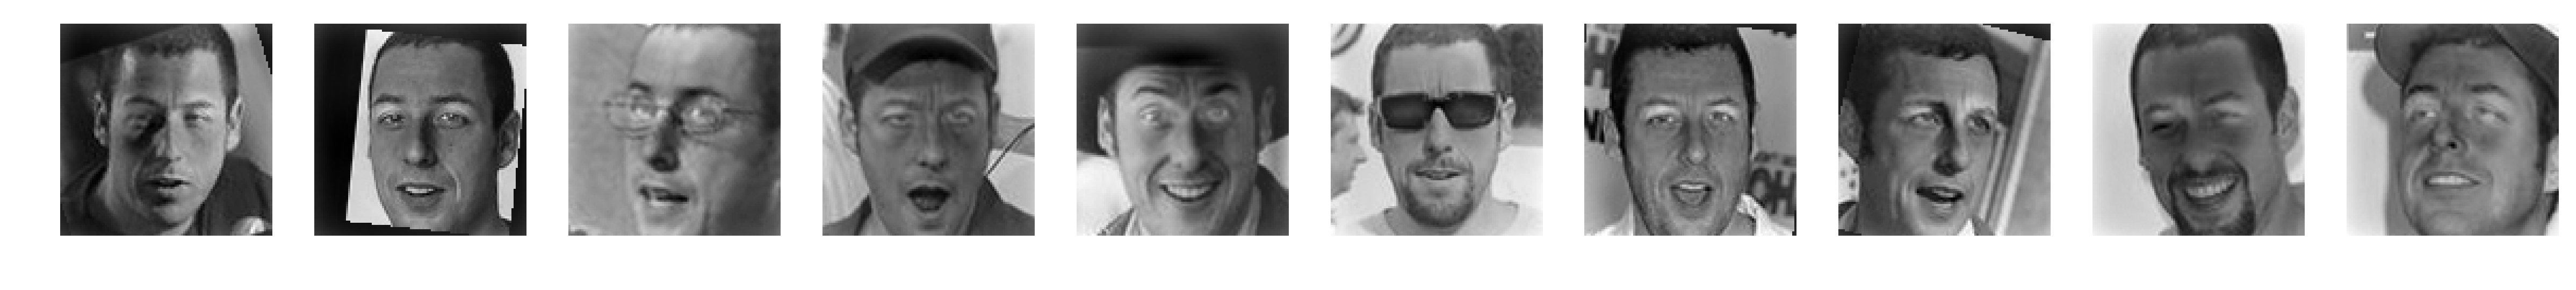

In [52]:
image_pil = preprocessing(train_files)
image_grid(image_pil[:10,:],H,W)


recognizer, labels = trainning_dataset(train_files, True)
print labels

#### Checking accuracy

In [53]:
def check_accuracy(image_paths,labels,recognizer, detect_faces=False):
    detector= cv2.CascadeClassifier("/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml");
    image_paths.sort()
    accuracy_list = []
    for image_path in image_paths:
#         predict_image_pil  = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        predict_image_pil = Image.open(image_path).convert('L')
        predict_image = np.array(predict_image_pil, np.uint8)
        predict_image = cv2.equalizeHist(predict_image)
        print image_path
        if detect_faces:
            faces = detector.detectMultiScale(predict_image)
            for (x, y, w, h) in faces:
                nbr_predicted, conf = recognizer.predict(predict_image[y: y + h, x: x + w])
                if nbr_predicted not in labels.keys():
                    accuracy_list.append(0)
                    continue
                predicted = labels[nbr_predicted]
                atual = get_label(image_path)
                if atual == predicted:
                    accuracy_list.append(1)
                    print "{} is Correctly Recognized with confidence {}".format(atual, conf)
                else:
                    accuracy_list.append(0)
                    print "{} is Incorrectly Recognized as {}".format(atual, predicted)
        else:
            nbr_predicted, conf = recognizer.predict(predict_image)
            atual = get_label(image_path)
            if nbr_predicted not in labels.keys():
                accuracy_list.append(0)
                continue
                
            predicted = labels[nbr_predicted]
            if atual == predicted:
                accuracy_list.append(1)
                print "{} is Correctly Recognized with confidence {}".format(atual, conf)
            else:
                accuracy_list.append(0)
                print "{} is Incorrectly Recognized as {}".format(atual, predicted)
    
    print "Total: {}".format(len(accuracy_list))
    accuracy_list = np.array(accuracy_list)
    found = np.where(accuracy_list == 1)
    print found
    print "Found: {}".format(len(found[0]))

    accuracy = float(len(found[0])) / len(accuracy_list)
    print "Accuracy is {}".format(accuracy)
    
    

In [55]:

check_accuracy(test_files,labels,recognizer, detect_faces=True )

faces2/test/Adam Sandler/103.jpg
faces2/test/Adam Sandler/132.jpg
Adam Sandler is Incorrectly Recognized as Brad Pitt
faces2/test/Adam Sandler/136.jpg
Adam Sandler is Correctly Recognized with confidence 105.470327437
faces2/test/Adam Sandler/26.jpg
Adam Sandler is Correctly Recognized with confidence 90.8368069765
faces2/test/Adam Sandler/270.jpg
Adam Sandler is Correctly Recognized with confidence 90.318389026
faces2/test/Adam Sandler/33.jpg
Adam Sandler is Correctly Recognized with confidence 105.790623606
faces2/test/Adam Sandler/37.jpg
Adam Sandler is Correctly Recognized with confidence 101.548561209
faces2/test/Adam Sandler/38.jpg
Adam Sandler is Correctly Recognized with confidence 99.6399284944
faces2/test/Adam Sandler/5.jpg
Adam Sandler is Correctly Recognized with confidence 96.8302654409
faces2/test/Adam Sandler/61.jpg
Adam Sandler is Correctly Recognized with confidence 105.177851566
faces2/test/Adam Sandler/80.jpg
Adam Sandler is Correctly Recognized with confidence 87.06

Avril Lavigne is Correctly Recognized with confidence 95.2344141139
faces2/test/Avril Lavigne/562.jpg
Avril Lavigne is Correctly Recognized with confidence 113.016839873
faces2/test/Avril Lavigne/659.jpg
Avril Lavigne is Correctly Recognized with confidence 109.021137556
faces2/test/Avril Lavigne/661.jpg
Avril Lavigne is Correctly Recognized with confidence 103.487892029
faces2/test/Avril Lavigne/695.jpg
faces2/test/Avril Lavigne/698.jpg
Avril Lavigne is Correctly Recognized with confidence 93.8365991692
faces2/test/Avril Lavigne/702.jpg
Avril Lavigne is Incorrectly Recognized as Cameron Diaz
faces2/test/Avril Lavigne/737.jpg
Avril Lavigne is Correctly Recognized with confidence 109.736573046
faces2/test/Avril Lavigne/75.jpg
Avril Lavigne is Incorrectly Recognized as Angelina Jolie
faces2/test/Barack Obama/100.jpg
Barack Obama is Correctly Recognized with confidence 110.643372549
faces2/test/Barack Obama/103.jpg
Barack Obama is Correctly Recognized with confidence 96.3672921248
faces2/

Brad Pitt is Correctly Recognized with confidence 118.902179695
faces2/test/Brad Pitt/987.jpg
Brad Pitt is Correctly Recognized with confidence 125.457241136
faces2/test/Cameron Diaz/103.jpg
Cameron Diaz is Incorrectly Recognized as Anna Kournikova
faces2/test/Cameron Diaz/132.jpg
Cameron Diaz is Correctly Recognized with confidence 115.42562256
faces2/test/Cameron Diaz/138.jpg
faces2/test/Cameron Diaz/142.jpg
Cameron Diaz is Incorrectly Recognized as Claudia Schiffer
faces2/test/Cameron Diaz/160.jpg
Cameron Diaz is Correctly Recognized with confidence 104.777097715
faces2/test/Cameron Diaz/167.jpg
Cameron Diaz is Correctly Recognized with confidence 101.365212837
faces2/test/Cameron Diaz/185.jpg
Cameron Diaz is Correctly Recognized with confidence 100.217852659
faces2/test/Cameron Diaz/203.jpg
Cameron Diaz is Correctly Recognized with confidence 106.518880835
faces2/test/Cameron Diaz/211.jpg
Cameron Diaz is Correctly Recognized with confidence 109.981010387
faces2/test/Cameron Diaz/21

Claudia Schiffer is Correctly Recognized with confidence 103.684818366
faces2/test/Claudia Schiffer/47.jpg
Claudia Schiffer is Correctly Recognized with confidence 111.378234024
faces2/test/Claudia Schiffer/53.jpg
Claudia Schiffer is Correctly Recognized with confidence 103.619147441
faces2/test/Claudia Schiffer/80.jpg
Claudia Schiffer is Incorrectly Recognized as Barack Obama
faces2/test/Clive Owen/100.jpg
faces2/test/Clive Owen/103.jpg
faces2/test/Clive Owen/138.jpg
faces2/test/Clive Owen/142.jpg
faces2/test/Clive Owen/160.jpg
faces2/test/Clive Owen/210.jpg
faces2/test/Clive Owen/211.jpg
faces2/test/Clive Owen/215.jpg
faces2/test/Clive Owen/218.jpg
faces2/test/Clive Owen/255.jpg
faces2/test/Clive Owen/37.jpg
faces2/test/Clive Owen/75.jpg
Clive Owen is Incorrectly Recognized as Cate Blanchett
faces2/test/Clive Owen/91.jpg
Total: 273
(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  16,
        18,  19,  20,  22,  23,  25,  28,  29,  30,  32,  33,  35,  39,
        4

### A Deep Learning Model

#### Custom Model

In [82]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(100,100,3)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               8000100   
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
__________

In [83]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [84]:
from keras.callbacks import ModelCheckpoint  
### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

trainning_result = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 2245 samples, validate on 277 samples
Epoch 1/10
2245/2245 [==============================] - 67s - loss: 2.7428 - acc: 0.1100 - val_loss: 2.6204 - val_acc: 0.1372
Epoch 2/10
2245/2245 [==============================] - 69s - loss: 2.5543 - acc: 0.1875 - val_loss: 2.3818 - val_acc: 0.3105
Epoch 3/10
2245/2245 [==============================] - 70s - loss: 2.3135 - acc: 0.2762 - val_loss: 2.1266 - val_acc: 0.3032
Epoch 4/10
2245/2245 [==============================] - 70s - loss: 1.9409 - acc: 0.3831 - val_loss: 1.8492 - val_acc: 0.4729
Epoch 5/10
2245/2245 [==============================] - 70s - loss: 1.6243 - acc: 0.4788 - val_loss: 1.5490 - val_acc: 0.5018
Epoch 6/10
2245/2245 [==============================] - 76s - loss: 1.3449 - acc: 0.5768 - val_loss: 1.5944 - val_acc: 0.5126
Epoch 7/10
2245/2245 [==============================] - 74s - loss: 1.1466 - acc: 0.6423 - val_loss: 1.3508 - val_acc: 0.5921
Epoch 8/10
2245/2245 [==============================] - 76s - loss: 0.9

### Visualize the model performance

In [85]:

train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(epochs)

#### Visualizing Loss

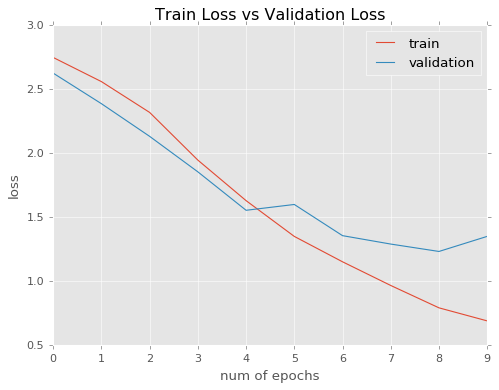

In [86]:
plt.figure(1,figsize=(7,5))
plt.plot(xc, train_loss)
plt.plot(xc, validation_loss)
plt.xlabel('num of epochs')
plt.ylabel('loss')
plt.title('Train Loss vs Validation Loss')
plt.grid(True)
plt.legend(['train', 'validation'])
plt.style.use(['ggplot'])
plt.show()


#### Visualizing Accuracy

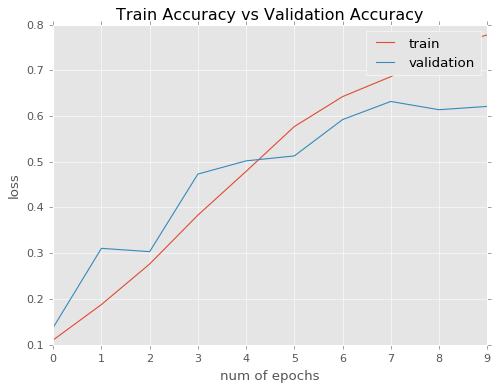

In [87]:
plt.figure(1,figsize=(7,5))
plt.plot(xc, train_acc)
plt.plot(xc, validation_acc)
plt.xlabel('num of epochs')
plt.ylabel('loss')
plt.title('Train Accuracy vs Validation Accuracy')
plt.grid(True)
plt.legend(['train', 'validation'])
plt.style.use(['ggplot'])
plt.show()

In [89]:
score = model.evaluate(test_tensors,test_targets, verbose=0)

In [90]:
print('Test Loss: ', score[0])
print('Test Accurary: ', score[1])

('Test Loss: ', 1.1810882193337979)
('Test Accurary: ', 0.64412811260630654)


TypeError: Invalid dimensions for image data

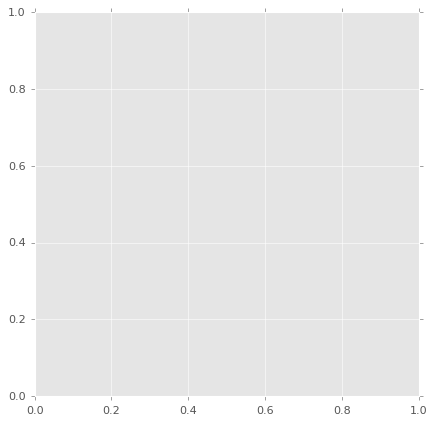

In [103]:
img = test_tensors[0:1]
# img = image.img_to_array(img)
plt.imshow(img/255)
plt.show()


In [101]:
print(model.predict(test_image))

ValueError: Error when checking : expected conv2d_7_input to have 4 dimensions, but got array with shape (100, 100)